In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(1)

<h2> Tratamiento de los datos </h2>

<h3>Carga de los datos y de las rutas de las imagenes</h3>

En primer lugar elaboraremos un dataframe elaborado con Pandas en el que incluiremos las rutas de las imagenes, su identificación, la clase de cancer, su edad, su tipo de operación si es que ha realizado alguna y su supervivencia.
Tambien serán eliminados los campos que no sean importantes como las identificaciones de otros años.


In [2]:
directory_path = 'G:\Dataset'
os.chdir(directory_path)

survival_path = os.path.join(directory_path, 'survival_info.csv')
survival_dataframe = pd.read_csv(survival_path, header=0, index_col='Brats20ID')
survival_dataframe.index.names = ['ID']

grade_dataframe = os.path.join(directory_path, 'name_mapping.csv')
grade_dataframe = pd.read_csv(grade_dataframe, header=0, index_col='BraTS_2020_subject_ID')
grade_dataframe.index.names = ['ID']

In [3]:
dataframe = grade_dataframe.join(survival_dataframe)
dataframe.drop(columns=['BraTS_2017_subject_ID', 'BraTS_2018_subject_ID', 'TCGA_TCIA_subject_ID', 'BraTS_2019_subject_ID'], inplace=True)
dataframe.head()
dataframe.describe(include = 'all')

,Grade,Age,Survival_days,Extent_of_Resection
count,369,236.000000,236,129
unique,2,NaN,218,2
top,HGG,NaN,82,GTR
freq,293,NaN,3,119
mean,NaN,61.223203,NaN,NaN
std,NaN,11.874114,NaN,NaN
min,NaN,18.975000,NaN,NaN
25%,NaN,54.244250,NaN,NaN
50%,NaN,61.471000,NaN,NaN
75%,NaN,69.200000,NaN,NaN


In [4]:
#dataframe = dataframe.reindex(columns = ['Grade', 'Age', 'Survival_days', 'Extent_of_Resection', 't1', 't1ce', 't2', 'flair'])
dataframe.rename(columns={'Grade':'grade', 'Age':'age','Survival_days':'survival_days','Extent_of_Resection':'extent_of_resection'}, inplace=True)

In [5]:
def load_image_path(dataframe, directory_path):
    '''
    '''
    images=['_t1.nii', '_t1ce.nii', '_t2.nii', '_flair.nii']
    for ID in dataframe.index:
        dataframe.at[ID, 't1'] = os.path.join(directory_path, ID, ID+images[0])
        dataframe.at[ID, 't1ce'] = os.path.join(directory_path, ID, ID+images[1])
        dataframe.at[ID, 't2'] = os.path.join(directory_path, ID, ID+images[2])
        dataframe.at[ID, 'flair'] = os.path.join(directory_path, ID, ID+images[3])
    return dataframe

In [6]:
dataframe = load_image_path(dataframe, directory_path)
dataframe.head()

,grade,age,survival_days,extent_of_resection,t1,t1ce,t2,flair
ID,,,,,,,,
BraTS20_Training_001,HGG,60.463,289,GTR,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...
BraTS20_Training_002,HGG,52.263,616,GTR,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...
BraTS20_Training_003,HGG,54.301,464,GTR,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...
BraTS20_Training_004,HGG,39.068,788,GTR,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...
BraTS20_Training_005,HGG,68.493,465,GTR,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...


<h3>Preprocesado de los datos</h3>

In [7]:
#Analizando los datos podemos observar que todos los pacientes con un grado de tumor bajo no tienen datos de supervivencia ni de
#extracción del tumor, ni edad. Esto es en gran medida porque estos pacientes tienen un pronostico bastante favorable [1] y la mayoria no necesita cirugia.
#Por eso asumiremos que ninguno de ellos se realizo cirugía, su edad será fijada de forma aleatoria entre el minimo y el maximo de las edades y el tiempo de supervivencia sera aleatorio entre 
#https://www.analesdepediatria.org/es-gliomas-bajo-grado-revision-10-articulo-S1695403314000873#:~:text=La%20supervivencia%20global%20fue%20del%2088%2C3%25%2C%20con%20una,fue%20del%2083%2C7%25.
#https://ascopubs.org/doi/full/10.1200/JOP.2016.018622#:~:text=A%20larger%20study%20of%20216,of%20resection%20was%20%3C%2090%25.

#Segun el estudio [2] un 76% de las personas con una extirpación de menos del 90% del tumor sobrevivieron más de 5 años. Por lo que
#como asumimos que estas personas no se realizaron cirugía ya que no tenemos datos, calcularemos el tiempo de supervivencia como un número
#aleatorio entre 4 y 7 teniendo un 24% de ser entre 4-5 y un 76% de ser entre 5-7
#En cuanto a la edad esta será calcula aleatoriamente en el rango de la media del resto de las edades con la desviacion tipica [media-dt, media+dt] 
dataframe.loc[(dataframe['grade'] != 'HGG') & (pd.isna(dataframe['age']) == True)].head(50)

,grade,age,survival_days,extent_of_resection,t1,t1ce,t2,flair
ID,,,,,,,,
BraTS20_Training_260,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...,G:\Dataset\BraTS20_Training_260\BraTS20_Traini...
BraTS20_Training_261,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...,G:\Dataset\BraTS20_Training_261\BraTS20_Traini...
BraTS20_Training_262,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...,G:\Dataset\BraTS20_Training_262\BraTS20_Traini...
BraTS20_Training_263,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...,G:\Dataset\BraTS20_Training_263\BraTS20_Traini...
BraTS20_Training_264,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...,G:\Dataset\BraTS20_Training_264\BraTS20_Traini...
BraTS20_Training_265,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_265\BraTS20_Traini...,G:\Dataset\BraTS20_Training_265\BraTS20_Traini...,G:\Dataset\BraTS20_Training_265\BraTS20_Traini...,G:\Dataset\BraTS20_Training_265\BraTS20_Traini...
BraTS20_Training_266,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_266\BraTS20_Traini...,G:\Dataset\BraTS20_Training_266\BraTS20_Traini...,G:\Dataset\BraTS20_Training_266\BraTS20_Traini...,G:\Dataset\BraTS20_Training_266\BraTS20_Traini...
BraTS20_Training_267,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_267\BraTS20_Traini...,G:\Dataset\BraTS20_Training_267\BraTS20_Traini...,G:\Dataset\BraTS20_Training_267\BraTS20_Traini...,G:\Dataset\BraTS20_Training_267\BraTS20_Traini...
BraTS20_Training_268,LGG,NaN,NaN,NaN,G:\Dataset\BraTS20_Training_268\BraTS20_Traini...,G:\Dataset\BraTS20_Training_268\BraTS20_Traini...,G:\Dataset\BraTS20_Training_268\BraTS20_Traini...,G:\Dataset\BraTS20_Training_268\BraTS20_Traini...


In [8]:
def generate_survival(dataframe):
    '''
    '''
    a=4
    b=5
    c=7
    probability_low = 24
    indexes = dataframe.loc[(pd.isna(dataframe['age']) == True)].index
    survival_fill = pd.DataFrame([0 for i in range(0, len(indexes))], columns=['fill'], index=indexes)
    for i in indexes.values:
        low = np.random.randint((a*365), high=(b*365)+1)
        high = np.random.randint((b*365), high=(c*365)+1)
        probability = np.random.randint(1, high=101)
        
        if probability <= probability_low:
            survival_fill.loc[i, 'fill'] = low
        else:
            survival_fill.loc[i, 'fill'] = high
            
    return survival_fill['fill']

def generate_age(dataframe):
    '''
    '''
    indexes = dataframe.loc[(pd.isna(dataframe['age']) == True)].index
    age_fill = pd.DataFrame([0 for i in range(0, len(indexes))], columns=['fill'], index=indexes)
    
    ages = dataframe.loc[pd.isna(dataframe['age']) == False]
    age_mean = np.round(ages.mean(), 3)
    age_std = np.round(ages.std(), 3)
    minimo = age_mean-age_std
    maximo = age_mean+age_std
    
    for i in indexes.values:
        random = np.round(np.random.uniform(minimo, maximo), 3)
        age_fill.loc[i, 'fill'] = random
        
    return age_fill['fill']

def normalize_age(dataframe):
    '''
    '''
    max_value = dataframe['age'].max()
    min_value = dataframe['age'].min()
    dataframe['age'] = (dataframe['age'] - min_value) / (max_value - min_value)
    return dataframe

In [9]:
dataframe['survival_days'].fillna(generate_survival(dataframe), inplace=True)
dataframe['age'].fillna(generate_age(dataframe), inplace=True)
dataframe = normalize_age(dataframe)

grade_encoding = {'LGG':0, 'HGG':1}
dataframe['grade'] = dataframe['grade'].replace(grade_encoding)

dataframe.drop(dataframe.loc[dataframe['survival_days'] == 'ALIVE (361 days later)'].index, axis=0, inplace=True)
dataframe = dataframe.astype({"grade": int, 'survival_days':int})

dataframe['extent_of_resection'].fillna('NONE', inplace=True)
dataframe = pd.get_dummies(dataframe, columns=['extent_of_resection'], prefix='resection_')


In [10]:
dataframe.head()

,grade,age,survival_days,t1,t1ce,t2,flair,resection__GTR,resection__NONE,resection__STR
ID,,,,,,,,,,
BraTS20_Training_001,1,0.613030,289,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,G:\Dataset\BraTS20_Training_001\BraTS20_Traini...,1,0,0
BraTS20_Training_002,1,0.491866,616,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,G:\Dataset\BraTS20_Training_002\BraTS20_Traini...,1,0,0
BraTS20_Training_003,1,0.521979,464,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,G:\Dataset\BraTS20_Training_003\BraTS20_Traini...,1,0,0
BraTS20_Training_004,1,0.296896,788,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,G:\Dataset\BraTS20_Training_004\BraTS20_Traini...,1,0,0
BraTS20_Training_005,1,0.731681,465,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,G:\Dataset\BraTS20_Training_005\BraTS20_Traini...,1,0,0


<h3>Carga y preprocesado de las imagenes</h3>

In [11]:
#HU -1000 (aire) 800 (huesos son 1000, asi los evitamos)

In [12]:
import nibabel as nib
from scipy import ndimage
from tensorflow.keras.utils import to_categorical

class Data_generator():
    """
    Data generator
    """
    def __init__(self, dataframe, train_size, width, height, depth):
        self.dataframe = dataframe
        self.train_size = train_size
        self.width = width
        self.height = height
        self.depth = depth
        
    def generate_split_indexes(self):
        '''
        '''
        np.random.seed(1)
        permutation = np.random.permutation(len(self.dataframe))
        index = int(len(self.dataframe) * self.train_size)
        train_index = permutation[:index]
        test_index = permutation[index:]
        
        index = int(index * self.train_size)
        train_index, valid_index = train_index[:index], train_index[index:]
        
        return train_index, valid_index, test_index
    
    def read_scan(self, filepath):
        """Read and load volume"""
        # Read file
        img = nib.load(filepath)
        # Rotate the image to a fixed axes
        img = nib.as_closest_canonical(img)
        # Get raw data
        img = img.get_fdata()
        return img
    
    def normalize(self, img):
        """Normalize the volume"""
        minimun = -1000
        maximun = 800
        img[img < minimun] = minimun
        img[img > maximun] = maximun
        img = (img - minimun) / (maximun - minimun)
        img = img.astype("float64")
        return img
        
    def resize_volume(self, img):
        # Get current depth
        current_depth = img.shape[-1]
        current_width = img.shape[0]
        current_height = img.shape[1]
        # Compute depth factor
        depth = current_depth / self.depth
        width = current_width / self.width
        height = current_height / self.height
        depth_factor = 1 / depth
        width_factor = 1 / width
        height_factor = 1 / height
        
        # Resize across z-axis
        img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
        return img
    
    def preprocess_image(self, path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        # Read scan
        volume = self.read_scan(path)
        # Normalize
        volume = self.normalize(volume)
        # Resize width, height and depth
        volume = self.resize_volume(volume)
        return volume
    
    def generate_data(self, indexes, is_training, batch_size=32):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        # arrays to store our batched data
        t1, t1ce, t2, flair, text, survival_days, grade = [], [], [], [], [], [], []
        while True:
            for index in indexes:
                patient = self.dataframe.iloc[index]
                
                t1_path = patient['t1']
                t1ce_path = patient['t1ce']
                t2_path = patient['t2']
                flair_path = patient['flair']
                
                t1.append(self.preprocess_image(t1_path))
                t1ce.append(self.preprocess_image(t1ce_path))
                t2.append(self.preprocess_image(t2_path))
                flair.append(self.preprocess_image(flair_path))
                
                survival_days.append(patient['survival_days'])
                grade.append(to_categorical(patient['grade'], 2))
                
                text.append(patient[['age', 'resection__GTR', 'resection__NONE', 'resection__STR']])

                # Lo que hace yield es crear un generador, es decir, cuando se ejecute este trozo de código no se ejecuta
                # instantaneamente, sino que más adelante cuando internamente el programa llame a next se ejecutará el código
                # hasta que se encuentre un yield y ahí parará. Con el siguiente next volvera a hacer una iteración y así.
                if len(t1) >= batch_size:
                    yield [np.float32(t1), np.float32(t1ce), np.float32(t2), np.float32(flair), np.float32(text)], [np.float32(grade), np.float32(survival_days)]
                    t1, t1ce, t2, flair, text, survival_days, grade = [], [], [], [], [], [], []
                    
            if not is_training:
                break

In [29]:
train_size = 0.8
image_width = 110
image_height = 110
image_depth = 75
data_generator = Data_generator(dataframe, train_size, image_width, image_height, image_depth)
train_index, valid_index, test_index = data_generator.generate_split_indexes() 

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model

In [31]:
class GliomaModel():
    '''
    Clase que genera un modelo utilizado para predecir la supervivencia y el grado del glioma.
    Recibe 4 entradas, una para cada tipo de imagen t1, t1ce, t2 y flair. Cada entrada pasa por distintas capas y
    se unen en una capa que calcula la media. Desde esa capa salen dos ramas desde las cuales se obtiene la clasificación
    de la supervivencia y la clase.
    '''
    def crear_capa_individual(self, inputs):
        """
        Crea las capas individuales de cada entrada, las cuales están compuestas por diversas capas como convolucion 3d, 
        maxpooling, dropout...
        """ 
        x = layers.Conv3D(16, (3, 3, 3), padding="valid")(inputs)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling3D(pool_size=(3, 3, 3), strides=None, padding="valid")(x)
        
        x = layers.Dropout(0.50)(x)
        
        x = layers.Conv3D(32, (3, 3, 3), padding="valid")(x)#, strides=(2,2,2)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling3D(pool_size=(3, 3, 3), strides=None, padding="valid")(x)
        
        return x
    
    def crear_rama_grado(self, modelo, input_text):
        """
        crea la rama que predice el grado del tumor
        """
        rama_grado = layers.Conv3D(32, (3, 3, 3), padding="valid")(modelo)
        rama_grado = layers.Activation("relu")(rama_grado)
        #rama_grado = layers.MaxPooling3D(pool_size=(3, 3, 3))(rama_grado)
        rama_grado = layers.Dropout(0.5)(rama_grado)
        rama_grado = layers.Flatten()(rama_grado)
        rama_grado = layers.Concatenate()([rama_grado, input_text])
        rama_grado = layers.Dense(256)(rama_grado)
        rama_grado = layers.Dropout(0.5)(rama_grado)
        rama_grado = layers.Dense(2)(rama_grado)
        rama_grado = layers.Activation("softmax", name="grade_output")(rama_grado)
        
        return rama_grado
        
    def crear_rama_supervivencia(self, modelo, input_text):
        """
        crea la rama que predice la supervivencia del paciente
        """
        rama_supervivencia = layers.Conv3D(32, (3, 3, 3), padding="valid")(modelo)
        rama_supervivencia = layers.Activation("relu")(rama_supervivencia)
        #rama_supervivencia = layers.MaxPooling3D(pool_size=(3, 3, 3))(rama_supervivencia)
        rama_supervivencia = layers.Dropout(0.5)(rama_supervivencia)
        rama_supervivencia = layers.Flatten()(rama_supervivencia)
        rama_supervivencia = layers.Concatenate()([rama_supervivencia, input_text])
        rama_supervivencia = layers.Dense(256)(rama_supervivencia)
        rama_supervivencia = layers.Dropout(0.5)(rama_supervivencia)
        rama_supervivencia = layers.Dense(1)(rama_supervivencia)
        rama_supervivencia = layers.Activation("relu", name="survival_output")(rama_supervivencia)
        
        return rama_supervivencia
        
    def ensamblar_modelo(self, width, height, depth):
        """
        Ensambla todas las partes de la red.
        """
        input_shape = (height, width, depth, 1)
        input_t1 = layers.Input(shape=input_shape)
        input_t1ce = layers.Input(shape=input_shape)
        input_t2 = layers.Input(shape=input_shape)
        input_flair = layers.Input(shape=input_shape)
        input_text = layers.Input(shape=(4))
        
        rama_t1 = self.crear_capa_individual(input_t1)
        rama_t1ce = self.crear_capa_individual(input_t1ce)
        rama_t2 = self.crear_capa_individual(input_t2)
        rama_flair = self.crear_capa_individual(input_flair)
        
        avg = layers.Average()([rama_t1, rama_t1ce, rama_t2, rama_flair])
        
        rama_supervivencia = self.crear_rama_supervivencia(avg, input_text)
        rama_grado = self.crear_rama_grado(avg, input_text)
        
        model = Model(inputs= [input_t1, input_t1ce, input_t2, input_flair, input_text], outputs = [rama_grado, rama_supervivencia], name="glioma_model")
        
        return model

In [32]:
model = GliomaModel().ensamblar_modelo(image_width, image_height, image_depth)

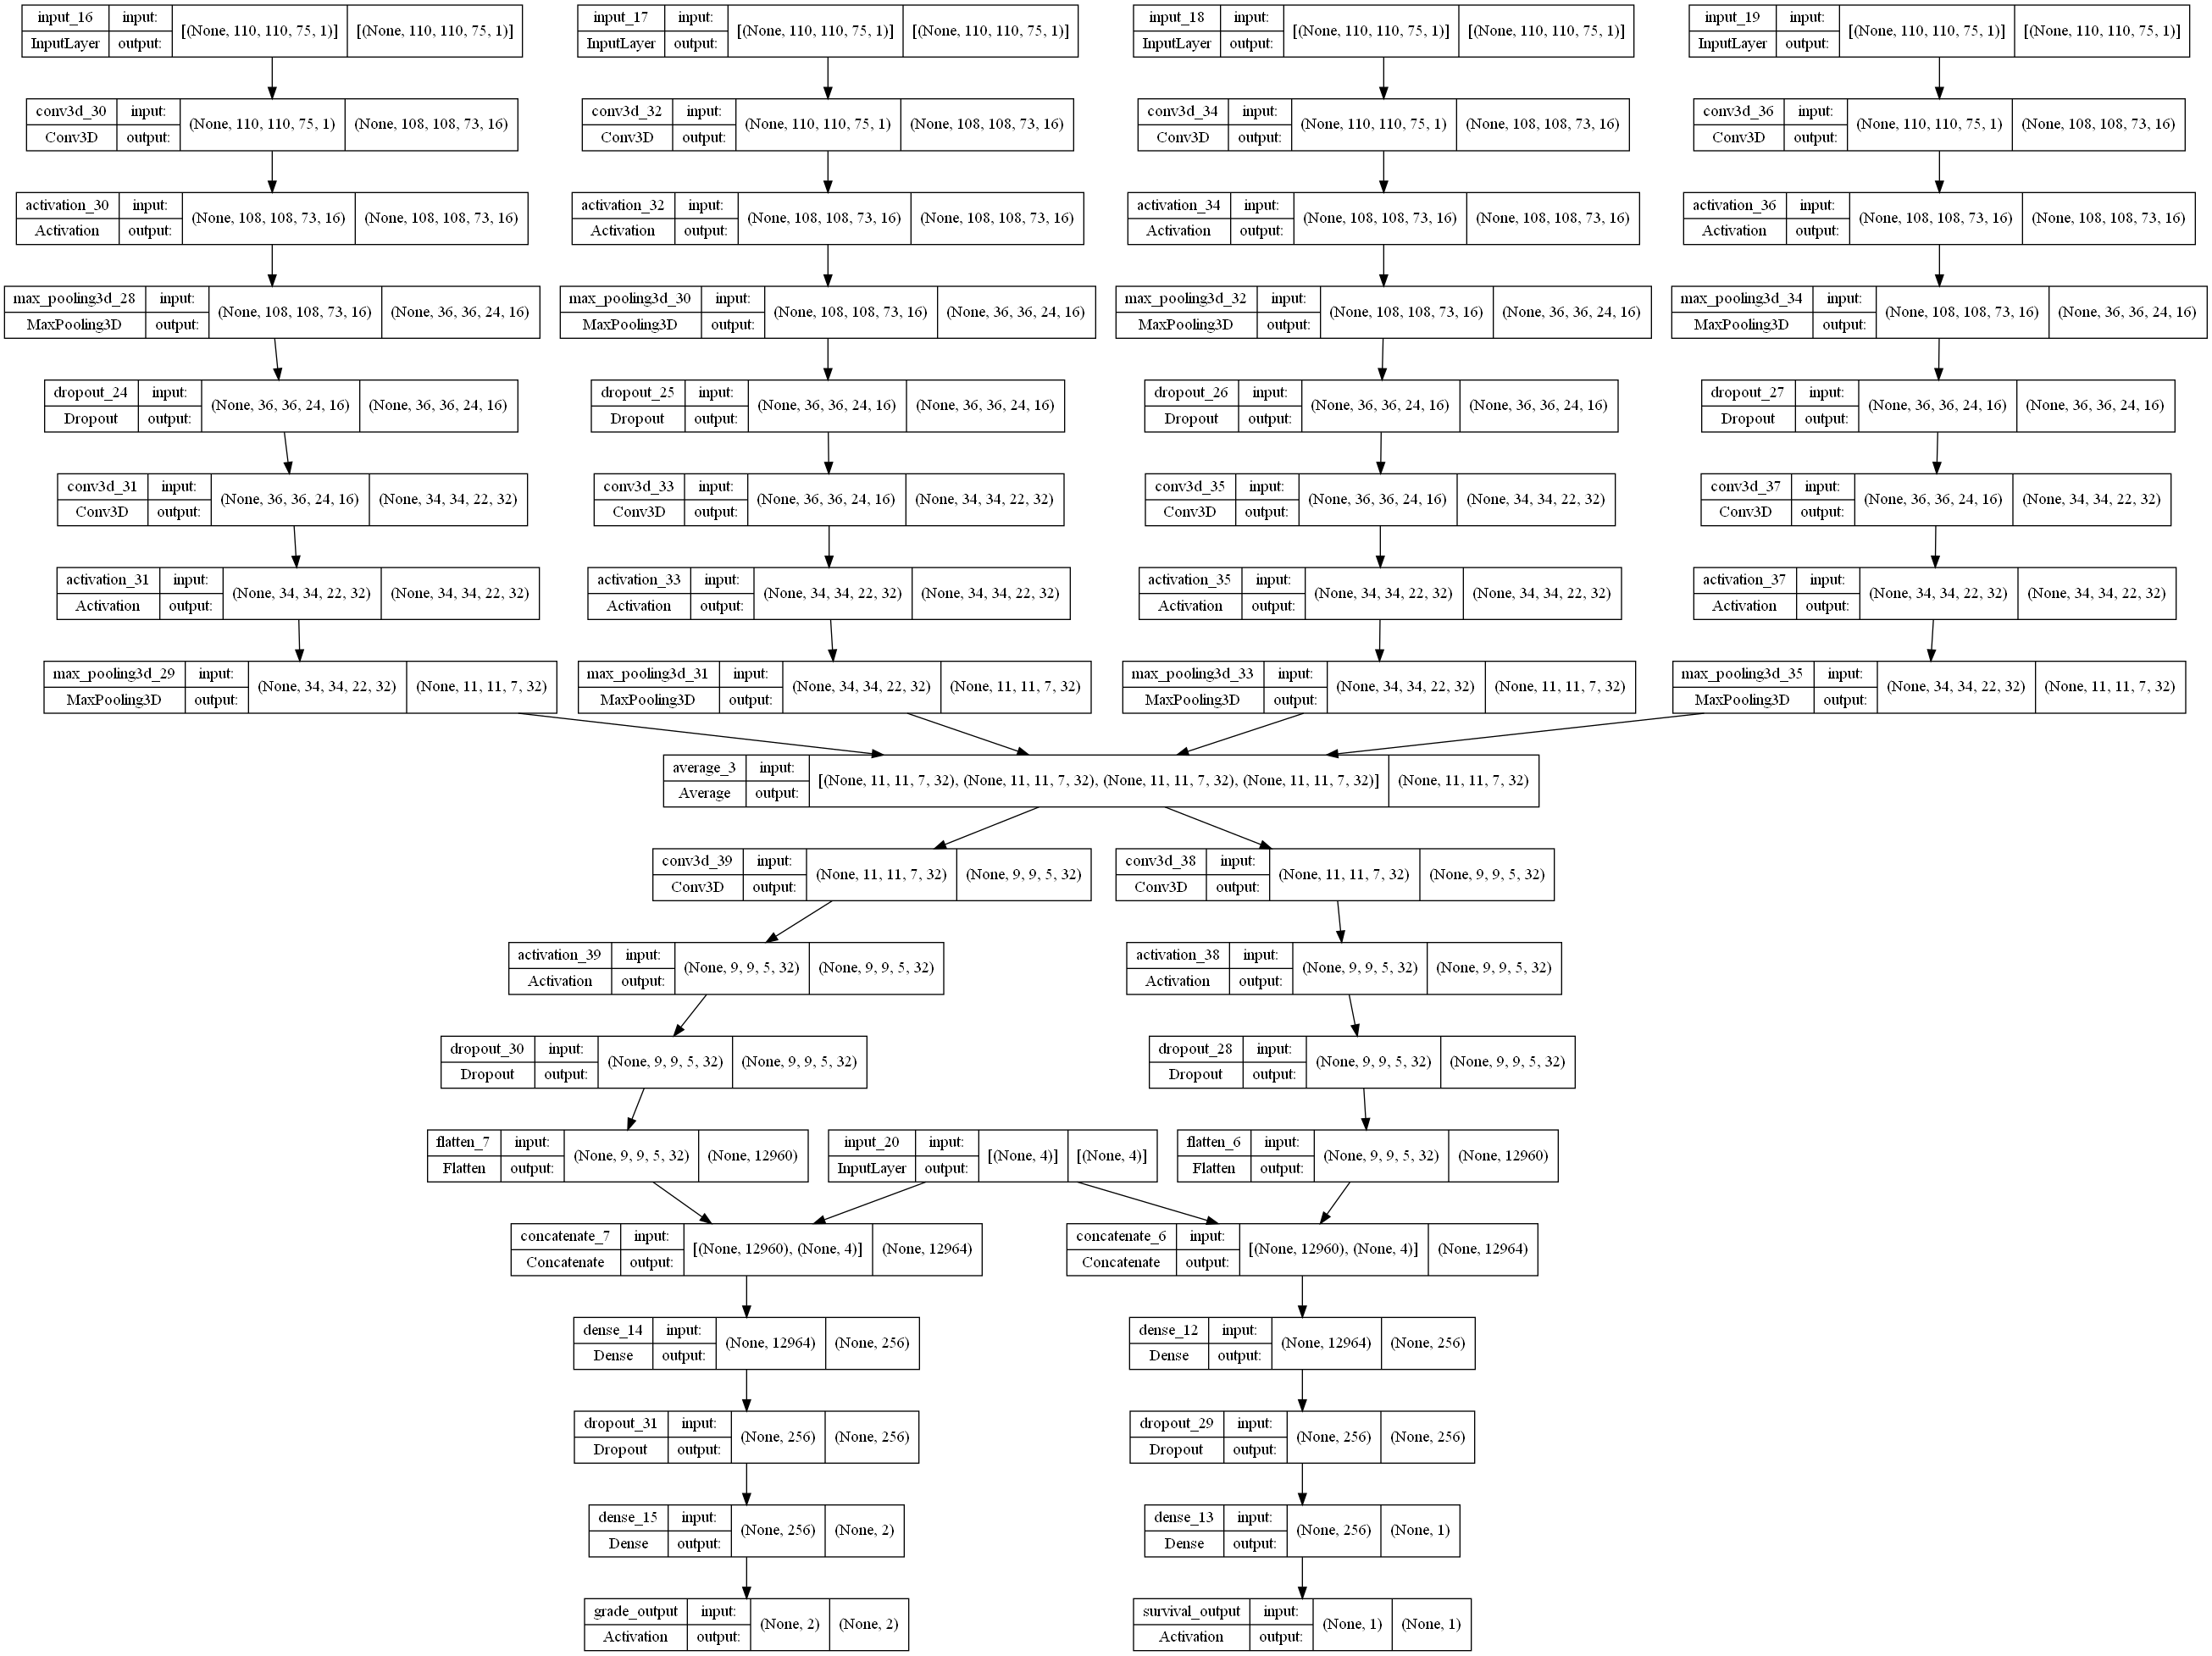

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)


In [34]:
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

init_lr = 1e-4
epochs = 5
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'survival_output': 'mse', 
                  'grade_output': 'binary_crossentropy'},
              metrics={
                  'survival_output': 'mae', 
                  'grade_output': 'accuracy'})

from keras.callbacks import ModelCheckpoint
batch_size = 8
valid_batch_size = 8
train_gen = data_generator.generate_data(train_index, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_data(valid_index, is_training=True, batch_size=valid_batch_size)

filepath = "./model_checkpoint"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [checkpoint]

#model = load_model(filepath)
history = model.fit(train_gen,
                    steps_per_epoch=len(train_index)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_index)//valid_batch_size,
                    verbose=1)

Epoch 1/5
29/29 [==============================] - ETA: 0s - loss: 1579743.1250 - grade_output_loss: 0.5821 - survival_output_loss: 1579742.6250 - grade_output_accuracy: 0.7759 - survival_output_mae: 937.1336 
Epoch 1: val_loss improved from inf to 1518645.37500, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
29/29 [==============================] - 536s 19s/step - loss: 1579743.1250 - grade_output_loss: 0.5821 - survival_output_loss: 1579742.6250 - grade_output_accuracy: 0.7759 - survival_output_mae: 937.1336 - val_loss: 1518645.3750 - val_grade_output_loss: 0.5288 - val_survival_output_loss: 1518644.8750 - val_grade_output_accuracy: 0.8036 - val_survival_output_mae: 926.5052
Epoch 2/5
 4/29 [===>..........................] - ETA: 6:25 - loss: 906376.3750 - grade_output_loss: 0.5048 - survival_output_loss: 906375.8125 - grade_output_accuracy: 0.8125 - survival_output_mae: 686.3645

KeyboardInterrupt: 

In [35]:
model = load_model(filepath)

test_batch_size = 4
test_generator = data_generator.generate_data(test_index, is_training=False, batch_size=test_batch_size)

grade_pred, survival_pred = model.predict(test_generator, steps=len(test_index)//test_batch_size)

In [36]:
grade_pred = np.argmax(grade_pred, axis=1)
grade_true = dataframe.iloc[test_index]['grade'][:-2]
survival_true = dataframe.iloc[test_index]['survival_days'][:-2]

from sklearn.metrics import classification_report
cr_grade = classification_report(grade_true, grade_pred, target_names=grade_encoding.keys())
print(cr_grade)

              precision    recall  f1-score   support

         LGG       0.00      0.00      0.00        16
         HGG       0.78      1.00      0.88        56

    accuracy                           0.78        72
   macro avg       0.39      0.50      0.44        72
weighted avg       0.60      0.78      0.68        72



D:\Programas\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
survival_pred = np.int_(survival_pred)

In [38]:
survival_pred

array([[118],
       [133],
       [143],
       [123],
       [123],
       [114],
       [143],
       [114],
       [115],
       [116],
       [139],
       [127],
       [145],
       [139],
       [125],
       [102],
       [114],
       [150],
       [119],
       [137],
       [147],
       [119],
       [124],
       [113],
       [119],
       [121],
       [146],
       [128],
       [138],
       [116],
       [112],
       [133],
       [113],
       [114],
       [148],
       [125],
       [109],
       [113],
       [130],
       [131],
       [141],
       [111],
       [109],
       [136],
       [119],
       [121],
       [147],
       [124],
       [119],
       [124],
       [124],
       [131],
       [128],
       [124],
       [110],
       [116],
       [123],
       [114],
       [137],
       [137],
       [137],
       [119],
       [115],
       [121],
       [119],
       [127],
       [114],
       [150],
       [119],
       [137],
       [142],
      